In [107]:
%load_ext autoreload
%autoreload 2

from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_time_plate_info_long_from_analysis 
from scipy.optimize import curve_fit

from amftrack.pipeline.final_analysis.density_wave import S
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *

import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.WARNING)
plates = ['94_20201123']
plate_select = [94]
import warnings
import scipy.stats as stats
import pandas as pd

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
all_analysis_folders = get_analysis_folders("data")
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info["time_since_begin"] = time_plate_info["time_since_begin"]/pd.Timedelta(hours = 1)
time_plate_info = time_plate_info.sort_values('time_since_begin')
time_plate_info['time_delta'] = -time_plate_info['time_since_begin'].diff(-1)
for index in range(20):
    time_plate_info[f"rhon-{index}"] = time_plate_info[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]


folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,time_plate_info_long = get_time_plate_info_long_from_analysis(analysis_folders,use_saved=False)
for index in range(20):
    time_plate_info_long[f"rhon-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]


In [102]:
def find_t0(index,table):
    column = f"ring_density_incr-100_index-{index}"

    start = np.min(
        table.loc[table[column] >= 400]["time_since_begin"]
    )
    table[f"time_since_begin_{index}"] = (
        table["time_since_begin"] - start
    )

    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = table
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    return(t0)

In [103]:
def plot_shade(df,xcolumn,ycolumn,color,ax):
    meancurve = df.groupby(xcolumn)[ycolumn].mean()
    stdcurve = df.groupby(xcolumn)[ycolumn].std()
    countcurve = df.groupby(xcolumn)[ycolumn].count()
    err = 2*stdcurve/np.sqrt(countcurve)
    ax.plot(meancurve.index,meancurve,color=color,linewidth = 1)
    ax.fill_between(meancurve.index, meancurve-err, meancurve+err,color=color,alpha = 0.4)
    return(meancurve)

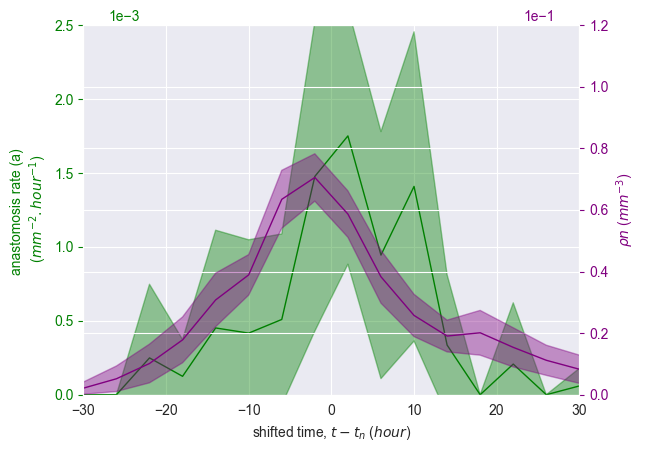

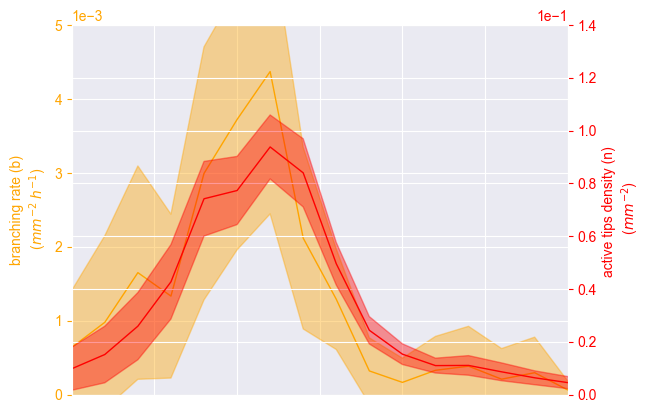

In [106]:

plate = 94

plt.close('all')
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
table_rh = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate].copy()

ts = []

ys = []
ys2 = []
ys3 = []
ys4 = []


for index in range(15):
    column = f"ring_anas_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    column3 = f"ring_branch_density_incr-100_index-{index}"
    column4 = f"rhon-{index}"
    
    start1 = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=400]['time_since_begin'])
    start = find_t0(index,table)+start1
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table_rh[column].astype(float).to_list()
        ys2+=table_rh[column2].astype(float).to_list()
        ys3+=table_rh[column3].astype(float).to_list()
        ys4+=(table_rh[column4].astype(float)/1000).to_list()
        
df = pd.DataFrame((np.array((ts,ys,ys2,ys3,ys4))).transpose(),columns=('ts','ys','ys2','ys3','ys4'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor+factor/2
xcolumn = 'ts_round'

f, ax = plt.subplots(1, 1, sharex=True)


ax3 = ax.twinx()
anas = plot_shade(df,xcolumn,'ys','green',ax)

rhon = plot_shade(df,xcolumn,'ys4','purple',ax3)
ax.set_ylabel('anastomosis rate (a) \n ($mm^{-2}.hour^{-1}$)', color='green')

ax.set_xlabel('shifted time, $t-t_n$ ($hour$)')
ax3.set_ylabel(r'$\rho n$ ($mm^{-3}$)', color='purple')
ax.set_ylim((0,0.0025))
ax3.set_ylim((0,0.12))

ax.tick_params(axis='y', colors='green')
ax3.tick_params(axis='y', colors='purple')
ax.set_xlim((-30,30))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.offsetText.set_position((0.05, 5))
ax3.yaxis.offsetText.set_position((0.95, 5))

# plt.savefig(os.path.join(path_figure,'Figure3D2.pdf'), bbox_inches='tight',transparent=True)

f, ax4 = plt.subplots(1, 1, sharex=True)
ax2 = ax4.twinx()

n = plot_shade(df,xcolumn,'ys2','red',ax2)
branch = plot_shade(df,xcolumn,'ys3','orange',ax4)
ax2.set_ylabel('active tips density (n) \n ($mm^{-2}$)', color='red')
ax4.set_ylabel('branching rate (b)\n ($mm^{-2}$ $h^{-1}$)', color='orange')
ax2.tick_params(axis='y', colors='red')
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim((0,0.0050))

ax2.set_xlim((-30,30))
ax2.set_ylim((0,0.140))
ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))



In [95]:
vzbrbr

NameError: name 'vzbrbr' is not defined

In [81]:
plate_id = '94_20201123'
plate_id_int = int(plate_id)
data,dy,select_movements = get_average_time_data(plate_id_int,time_hypha_info,2)
hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)


In [82]:
timesteps = []
hypha_hulls = []
for timestep,line in enumerate(hyphae_hull):
    timesteps += [timestep for hyph in hyphae_hull[line]]
    hypha_hulls += [hyph for hyph in hyphae_hull[line]]
data_front = pd.DataFrame((np.array((timesteps,hypha_hulls))).transpose(),columns=('timestep','label'))
data_front['timestep_label'] = data_front['timestep'].astype(str)+'_'+data_front['label'].astype(str)

In [83]:
select_movements['group_time'] = select_movements['timestep']//10
select_movements['timestep_label'] = select_movements['timestep'].astype(int).astype(str)+'_'+select_movements['end'].astype(int).astype(str)

select_movements['is_hull_pusher'] = select_movements["timestep_label"].isin(data_front['timestep_label'])
select = select_movements.loc[select_movements['timestep']<100]

C:\Users\coren\AppData\Local\Temp\ipykernel_21604\2868607031.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


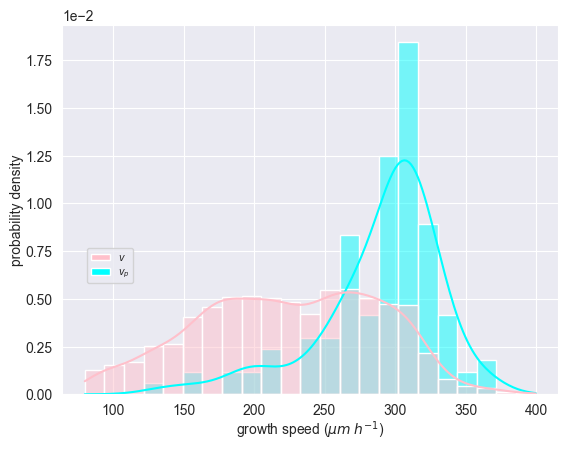

In [84]:
fig,ax = plt.subplots()

sns.set_palette(['pink', 'cyan', 'blue'])
g  = sns.histplot(data=select,x ='speed', kde=True,color="grey",hue = "is_hull_pusher",common_norm=False,ax=ax,stat="density")
ax.legend().remove()
legend_labels = {'v': 'pink', 'v_p': 'cyan'}
custom_handles = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in legend_labels.values()]
custom_labels = ["$v$",r"$v_p$"]

# Add the custom legend
ax.legend(custom_handles, custom_labels, fontsize='x-small',loc = (0.05,0.3))
ax.set_xlabel("growth speed ($\mu m$ $h^{-1}$)")
ax.set_ylabel("probability density")
ax.xaxis.labelpad = 1
ax.yaxis.labelpad = 1
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))



In [85]:
plates = [
"416_20230705",
"427_20230707",
"420_20230705",
"431_20230627",
"474_20230807",
"460_20230807",
"464_20230807",
"440_20230723",
"436_20230717",
"443_20230720",
"439_20230804",
"470_20230709",
'478_20230814', '468_20230809', '447_20230821', '487_20230922',
       '492_20230901', '471_20230821', '486_20231009',
       '494_20230908', '482_20230908', '495_20231013', '463_20231013',
       '491_20231013', '481_20231005', '483_20231005',
    '490_20231003',
       '485_20230929',
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_long_from_analysis(analysis_folders,False)
time_plate_info['unique_id'] = time_plate_info['unique_id'].replace(47020230709,47020230802)
time_plate_info=time_plate_info[time_plate_info['Plate']!=431]


In [86]:
C_max2 = 1.53

def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
# Read the Excel file
path = r'data'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']
df['totP (ug)'] = df['totP (ug)'] * fit_function(df['totP (ug)'], C_max2)
df['Sample_name'] = df['Sample_name'].str.replace('bottom','0')
df['Sample_name'] = df['Sample_name'].str.replace('up','1')
df['Sample_name'] = df['Sample_name'].str.replace('top','1')
df['Sample_name'] = df['Sample_name'].str.replace('agar','0')



df = df.loc[df['plate']!=487]

time_plate_info.sort_values(['unique_id', 'time_since_begin_h'], inplace=True)

# Group by unique_id and take the last entry for each group
last_values = time_plate_info.groupby('unique_id').last().reset_index()


grouped = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6
# df = df[df['type'] != 'sub']

grouped = grouped[grouped['plate']!=487]

# df['integrated_SA_C']=df['integrated_SA']/df['wet weight']
# grouped = dfgrouped = df.groupby(['plate', 'type',"time_elapsed_day","t1 (day)","treatment",'t2 (day)']).agg({'totP (ug)': 'sum', 'wet weight': 'sum','dry weight' : "sum",'integrated_SA':"sum"}).reset_index()
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
# Step 1: Identify plates that don't have any rows with type "agartot"
plates_with_agartot = grouped[grouped['type'] == 'rootagartot']['plate'].unique()
valid_plates = grouped[~grouped['plate'].isin(plates_with_agartot)]

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = valid_plates[valid_plates['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = valid_plates[valid_plates['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']

agar 0.7155728225338454
root 0.4487471204532695


Text(0, 0.5, '$m_P$ ($\\mu g$)')

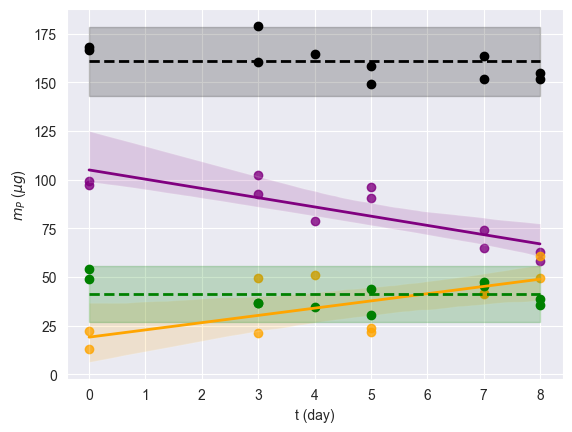

In [87]:

import seaborn as sns
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['t2 (day)']<=9]
select = select[select['plate']!=431]
select = select[select['plate']!=487]
column = 't2 (day)'
t2_values = select[column].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}

fig,ax = plt.subplots()
# Unique categories in the hue column
types = select['type'].unique()
color_dict = {
    'root': 'orange',
    'agar': 'purple',
    'rootagar': 'green'
}

# Iterate over each category
for type_obj in types:
    # Subset data for the category
    subset = select[select['type'] == type_obj]
    if type_obj == "rootagar":
        ax.scatter(subset[column], subset['fullP'], color=color_dict[type_obj])
        line_style = {"linestyle": "--","linewidth":4}  # Dashed line for 'rootagar'
        mean_value = subset['fullP'].mean()
        std_value = subset['fullP'].std()
        xmin = np.min(subset[column])
        xmax = np.max(subset[column])
        ax.hlines(y=mean_value, xmin = xmin,xmax = xmax, color=color_dict[type_obj], linestyle='--', linewidth = 2)
        ax.fill_between([xmin,xmax], mean_value - 2*std_value, mean_value + 2*std_value, color=color_dict[type_obj], alpha=0.2)
    else:
        line_style = {"linewidth":2}  # Default line style for other types

    # Create a regplot for the subset with customized line style for 'rootagar'
        sns.regplot(x=subset[column], y=subset['fullP'], color=color_dict[type_obj], line_kws=line_style)
        slope2, intercept, r_value, p_value, std_err = stats.linregress(subset[column], subset['fullP'])
    
        print(type_obj,r_value**2)
total = select.groupby("plate")
ax.scatter(total[column].mean(), total['fullP'].sum(), color="black")
mean_value = total['fullP'].sum().mean()
std_value = total['fullP'].sum().std()
ax.hlines(y=mean_value, xmin = np.min(total[column].mean()),xmax = np.max(total[column].mean()), color="black", linestyle='--', linewidth = 2)
ax.fill_between([xmin,xmax], mean_value - 2*std_value, mean_value + 2*std_value, color="black", alpha=0.2)
ax.set_xlabel('t (day)')
ax.set_ylabel('$m_P$ ($\mu g$)')


### Fig. 3e
Requires installing dolfin 2019.2.0.dev0 which cannot easily be done within a poetry environment. The following cell will only run with that specific version of dolfin installed. This can be done using something like (the right dolfin version could only be find in bvpy source files...)
```
conda env create -f env.yaml -n bvpy-dev
```


In [ ]:
DP = 1e-5 #cm**2-s-1, diffusion coefficient of small ions in water
DP = DP*1e2*3600 #mm**2-h-1, diffusion coefficient of small ions in water
C0 = 3.5 #ug/mL=ug/cm**-3
C0 = 3.5*1e-3 #ug/mm**-3
Vmax = 2e-5 #umol.cm-2/s-1
Vmax = Vmax*31 #ug.cm-2.s-1
Vmax = Vmax * 3600 #ug.cm-2.h-1
Vmax = Vmax *1e-2 #ug.mm-2.h-1
r0 = 5e-3 #mm
Km = 5e-3 #umol/cm3
Km *= 31 #ug/cm3
Km *=1e-3 #ug/mm3
Km_snchepf = Km
C0 = 500 #mg.L-1
C0 = 500*1e3 #ug.L-1
C0 = C0 * 1e-3 #ug.cm-3
C0 = C0 *1e-3 #ug.mm-3
from tqdm.notebook import tqdm  # Import tqdm
import matplotlib.ticker as ticker
cm = 1/2.54  # centimeters in inches
bp = 239
import matplotlib.pyplot as plt

plt.style.use('presentation.mplstyle')

from dolfin import *
import numpy as np
import matplotlib as mpl
cmap3 = mpl.cm.get_cmap("autumn")
cmap4 = mpl.cm.get_cmap("summer")

import os
Length = 140*1.5
nx = 350*15//10
plt.close("all")
set_log_active(False)
rho_value = 5
class Simulation:
    """
    A class for simulating a finite element problem using the FEniCS framework.

    Attributes:
    -----------
    Length: float
        Length of the interval domain.
    nx: int
        Number of subdivisions in the mesh.
    nT: int
        Number of time steps.
    T: float
        Total simulation time.
    C0: float
        Initial concentration value.
    Fmax: float
        Maximum flux value.
    Pprice_ideal: float
        Ideal price value.
    width: float
        Width of the plot.
    height: float
        Height of the plot.
    """
    def __init__(self, Length=Length, nx=nx, nT=200, T=400, C0=10, Fmax=2, Pprice_ideal=20, width=3*cm, height=7*cm,speed = 0.230,adaptation_rate = 1e-4,drag = 0):
        self.Length = Length
        self.nx = nx
        self.dx = Length/nx
        self.nT = nT
        self.T = T
        self.dt = T/nT
        self.C0 = C0 #ug.mm-3
        self.Fmax = Fmax
        self.Pprice_ideal = Pprice_ideal
        self.width = width
        self.height = height
        self.speed = speed
        self.adaptation_rate = adaptation_rate
        self.speed_penalty = drag
        self._setup_simulation()
        self.r0 = 3e-3

    def _setup_simulation(self):
        # Set up the simulation: define mesh, function spaces, initial conditions, etc.
        """
        Sets up the initial conditions and parameters for the simulation.
        """
        # Create mesh and define function space
        self.mesh = IntervalMesh(self.nx, 1, self.Length)
        P1 = FiniteElement('P', interval, 1)
        element = MixedElement([P1, P1, P1])
        self.V = FunctionSpace(self.mesh, element)

        # Define initial conditions
        u0 = Expression(('0.3*exp(-0.2*pow(abs(x[0]-7),2))', 
                         f'(1-exp(-0.1*(x[0]-1)))*{self.C0}', '0*exp(-0.01*pow(abs(x[0]),2))'), degree=1)
        rexp = Expression(('1/x[0]', '0', '0'), degree=1)
        self.r = interpolate(rexp, self.V)
        self.invr, _, _ = split(self.r)
        self.u_n = interpolate(u0, self.V)

        # Splitting functions for later use
        self.u = Function(self.V)
        self.n, self.C, self.rho = split(self.u)   #mm-3,ug.mm-3,mm2.mm-3
        self.n_n, self.C_n, self.rho_n = split(self.u_n)
        self.v_1, self.v_0, self.v_2 = TestFunctions(self.V)

        # Set parameters and constants
        self.dt = self.T / self.nT
        self.alphval = 0.039 #.h-1
        self.alphval0 = self.alphval
        self.betaval = 0.022 #mm.h-1 length coefficient
        # self.betaval = 0.022/(2.5e-3) #mm.h-1 SA coefficient
        
        self.beta = Constant(self.betaval) #mm**4.h-1
        self.D = 0.0008 #mm**2.h-1
        self.D0 = self.D #mm**2.h-1
        
        self.D2 = Constant(3.6) #mm**2.h-1
        self.n_mid = 0.5*(self.n_n + self.n)
        self.v_sval = self.speed #mm.h-1
        self.s_scal = self.speed #mm.h-1
        self.v_s = Constant((self.v_sval,)) #mm.h-1
        self.Vmax = self.Fmax #ug.mm**-2.h-1
        self.Kp = Km_snchepf #ug.mm-3
        # Boundary conditions
        u_L = (Constant(0.0), Constant(0.0), Constant(0.0))
        u_R = (Constant(0.0), Constant(self.C0), Constant(0.0))
        bc_L = DirichletBC(self.V, u_L, 'near(x[0], 1.0)')
        bc_R = DirichletBC(self.V, u_R, f'near(x[0], {self.Length})')
        self.bcs = [bc_L, bc_R]

    def _make_F(self, alphval,D,sval):
        # Define the variational problem F
        alpha = Constant(alphval)
        D = Constant(D)
        s_scal = Constant(sval)
        
        # dn/dt
        F = self.n*self.v_1*dx - self.n_n*self.v_1*dx 
        # D lapplacian(n)
        F += D*dot(grad(self.n), grad(self.v_1))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*D*dot(grad(self.n), Constant((1,)))*self.v_1*self.dt*dx
        
        #v.grad(n)
        F += self.dt*dot(grad(self.n_mid),self.v_s)*self.v_1*dx
        # To account for cylindrical coordinates
        F += self.invr*self.dt*self.n_mid*Constant(self.v_sval)*self.v_1*dx
        
        #alpha*n - beta * n * rho
        F += self.beta*self.v_1*self.rho*(self.n)*self.dt*dx
        F -= alpha*(self.n)*self.v_1*self.dt*dx
        #d rho/dt = vn
        F -= self.dt*s_scal*self.n*self.v_2*dx-(self.rho-self.rho_n)*self.v_2*dx


        # dC/dt
        F += self.C*self.v_0*dx - self.C_n*self.v_0*dx #ug.mm-3
        # Vmax * rho * C/(C+Kp)
        F += 2*np.pi*self.Vmax*(self.rho)*self.r0*(self.C/bp/(self.Kp+self.C/bp))*self.v_0*self.dt*dx #ug
        # Diffusion 
        F += self.D2*dot(grad(self.C/bp), grad(self.v_0))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*self.D2*dot(grad(self.C/bp), Constant((1,)))*self.v_0*self.dt*dx

        return F
    def integrate(self, plot=False,remove_ylabels = False):
        """
        Integrate the problem over time and optionally plot the results.
        Returns arrays of C(x, t), rho(x, t), and n(x, t) over the simulation.

        Parameters:
        -----------
        plot: bool
            If True, plot the results using matplotlib.

        Returns:
        --------
        C_xt: list of arrays
            Concentration C as a function of position x and time t.
        rho_xt: list of arrays
            Density rho as a function of position x and time t.
        n_xt: list of arrays
            Quantity n as a function of position x and time t.
        """
        # Initialize arrays to store C(x, t), rho(x, t), and n(x, t)
        C_xt = []
        rho_xt = []
        n_xt = []
        P_prices = []
        alphavals = []
        # Initialize matplotlib plots if needed
        if plot:
            fig, axs = plt.subplots(4, 1, figsize=(self.width, self.height*1.5))
            cmap = mpl.cm.get_cmap("winter")
            cmap2 = mpl.cm.get_cmap("spring")

        # Time-stepping loop
        V2 = FunctionSpace(self.mesh, 'P', 1)
        X = np.linspace(1, self.Length, self.nx)
        i=0
        for t in tqdm(np.linspace(0, self.T, self.nT), desc="Simulating"):
            F = self._make_F(self.alphval,self.D,self.s_scal)
            solve(F == 0, self.u, self.bcs)
            self.u_n.assign(self.u)
            _n, _C, _rho = self.u.split()

            # Interpolate and store the results
            n_field = interpolate(_n, V2)
            rho_field = interpolate(_rho, V2)
            C_field = interpolate(_C, V2)
            Ccost = np.sum([n_field(x)*x*self.dx*self.v_sval for x in X]) #mm.h-1.mm-1
            Ccost *= np.pi*(self.r0)**2 #mm**3.mm-1.h-1
            Ccost *= 1e-3  #mL.mm-1.h-1=dm**3.mm-1.h-1
            
            Ccost *= 0.5*0.21*1.1 #g.mm-1.h-1
            Ccost *= 1e6 #ug.mm-1.h-1
            Ccost *= 2 #respiration
            Ccost *= (self.v_sval/0.25)**(self.speed_penalty)
            Pacquisition = np.sum([self.Vmax*(C_field(x)/bp/(C_field(x)/bp+self.Kp))*rho_field(x)*x*self.dx for x in X]) #ug.h-1.mm-2
            Pacquisition *= 2*self.r0*np.pi #ug.h-1.mm-1
            # Pacquisition += 5e-4*np.exp(-t/100)
            
            Pprice = Ccost/Pacquisition

            alphavals.append(self.alphval)
            # if t>=10:
                # self.s_scal = self.Pprice_ideal/Pprice*self.speed
                # self.alphval = max(0.001,self.alphval + self.dt*self.adaptation_rate*signed_sqrt((self.Pprice_ideal-Pprice)/self.Pprice_ideal,alpha = 1))
            # print(self.alphval)
            self.D = self.D0*self.alphval0/self.alphval
            # print(2*(np.sqrt(self.D*self.alphval)))
            n_xt.append([n_field(x) for x in X])
            rho_xt.append([rho_field(x) for x in X])
            C_xt.append([C_field(x) for x in X])
            P_prices.append(Pprice)
            # print(Pprice,self.alphval)
            if plot and i % (self.nT//5) == 0:
                axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
                axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
                axs[2].plot(X, np.array(C_xt[-1])*1000, color=cmap3(t / self.T))
                Pacq =  [2*self.r0*np.pi*C_xt[-1][i]/bp/(C_xt[-1][i]/bp+self.Kp) * rho_xt[-1][i]*Vmax*1000 for i in range(len(X))]
                
                axs[3].plot(X, Pacq, color=cmap4(t / self.T))
                # break
            i+=1
            

        # Finalize plot settings if plotting
        if plot:
            axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
            axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
            satrho = np.median([rho for rho in rho_xt[-1] if rho>1e-10])
            
            # axs[0].hlines(satrho,np.min(X),np.max(X), color="red")
            
            axs[2].plot(X, np.array(C_xt[-1])*1000, color=cmap3(t / self.T))
            Pacq =  [2*self.r0*np.pi*C_xt[-1][i]/bp/(C_xt[-1][i]/bp+self.Kp) * rho_xt[-1][i]*Vmax*1000 for i in range(len(X))]
            axs[3].plot(X, Pacq, color=cmap4(t / self.T))
            axs[0].set_ylabel(r'$\rho$'+ '\n $(mm^{-2})$')
            axs[0].set_xticklabels([])
            # axs[0].set_ylim(0,3.5)
            
            axs[1].set_ylabel('$n$ \n $(mm^{-3})$')
            axs[1].set_xticklabels([])
            # axs[1].set_ylim(0,1.5)
            
            axs[2].set_ylabel('$[P]$ \n ($ng/ mm^{3}$)')
            axs[2].set_xticklabels([])
            
            axs[3].set_ylabel('$\phi_P$ \n ($ng/mm^{3}/h$)')

            axs[3].set_xlabel('position \n ($mm$)')
            # axs[3].set_ylim(0,0.60)

            formatter = ticker.FormatStrFormatter('%.2f')  # Adjust format as needed

            for ax in axs:
                ax.yaxis.set_major_formatter(formatter)
            if remove_ylabels:
                for ax in axs:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

            plt.show()

        return C_xt, rho_xt, n_xt,P_prices,alphavals
    
cm = 1/2.54  # centimeters in inches


# Example usage:
C0=0.02 #ug.mm-3
Pprice_ideal = C0/C0**(1/3)
speed = 0.10
sim = Simulation(speed = speed,C0=C0,T = 600,nT=600,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = 3e-4,drag = 1, width=6*cm, height=4*cm)
C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)